In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# assign the station class to a variable called `Station`
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [21]:
# Find the most recent date in the data set.
Latest_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Latest_Date

('2017-08-23',)

In [30]:
# Query all columns
result = session.query(Measurement).all()

# Print the first few results to see the structure
for row in result[:1]:
    print(row.__dict__)

# Get column names
column_names = Measurement.__table__.columns.keys()
print("Column names:", column_names)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x155359960>, 'tobs': 18.3, 'id': 0, 'date': '2010-01-01', 'station': 'USC00519397', 'prcp': 2.0}
Column names: ['id', 'station', 'date', 'prcp', 'tobs']


In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
Latest_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= dt.date(2017, 8, 23)).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values('date')

<Figure size 1000x600 with 0 Axes>

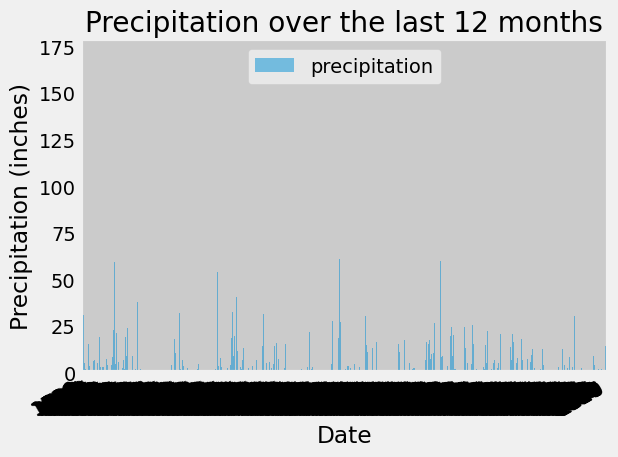

In [42]:

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))

# Plot the data
df.plot(kind='bar', width=1, alpha=0.5)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation over the last 12 months')

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
summary_stats

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [55]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [57]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Design the query
station_activity = session.query(Measurement.station, func.count(Measurement.id).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).\
    all()

# Print the results
print("Most active stations:")
for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")

Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [61]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#get the id of the most active station
most_active_station_id = station_activity[0][0]

# calculate the temperature statistics for the most active station
temp_stats = session.query(func.min(Measurement.tobs).label('lowest_temp'),
                           func.max(Measurement.tobs).label('highest_temp'),
                           func.avg(Measurement.tobs).label('average_temp')).\
    filter(Measurement.station == most_active_station_id).\
    one()

# Print the results
print(f"Statistics for the most active station ({most_active_station_id}):")
print(f"Lowest temperature: {temp_stats.lowest_temp}")
print(f"Highest temperature: {temp_stats.highest_temp}")
print(f"Average temperature: {temp_stats.average_temp:.3f}")


Statistics for the most active station (USC00519281):
Lowest temperature: 12.2
Highest temperature: 29.4
Average temperature: 22.036


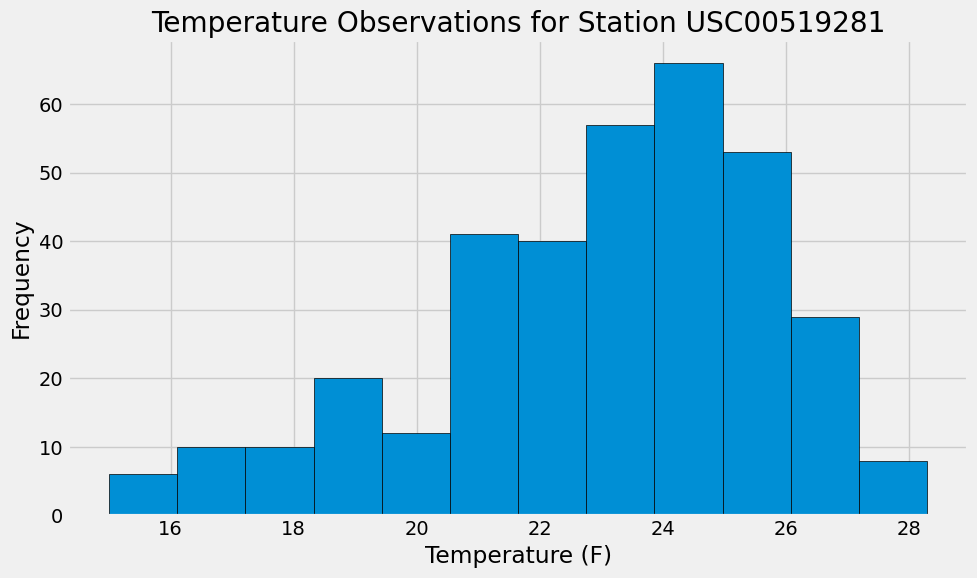

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date).\
    all()


# Unpack the results
temps = [temp.tobs for temp in temperature_results]

# Create the histogram
plt.figure(figsize=(10,6))
plt.hist(temps, bins=12, edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station_id}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [64]:
# Close Session
session.close()
